## Load DATA

In [23]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [24]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [25]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [26]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [27]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [28]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [29]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [30]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [31]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [32]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x143b01de0>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1439123b0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x144146ef0>)],
                  verbose=True)

In [33]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [1]:
features_config_get = {}

In [35]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [36]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-14 19:13:45,779: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-14 19:13:45,804: INFO: Initialisation des features
root 2024-11-14 19:13:45,807: INFO: Fetching data for hospitalfeatures at CHU Dijon


root 2024-11-14 19:13:47,970: INFO: Fetching data for airqualityfeatures at CHU Dijon
root 2024-11-14 19:13:48,145: INFO: Fetching data for epidemiologicalfeatures at CHU Dijon
root 2024-11-14 19:13:48,318: INFO: Fetching data for googletrendfeatures at CHU Dijon
root 2024-11-14 19:13:48,519: INFO: Fetching data for meteorologicalfeatures at CHU Dijon
root 2024-11-14 19:13:48,694: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-11-14 19:13:48,909: INFO: Fetching data for sportscompetitionfeatures at CHU Dijon
root 2024-11-14 19:13:49,092: INFO: Fetching data for trafficfeatures at CHU Dijon
root 2024-11-14 19:13:49,454: INFO: Getting the dataset from 01-01-2019 to 30-12-2023 for [<src.location.location.Location object at 0x1446ecd30>]
root 2024-11-14 19:13:49,636: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:49,650: INFO: Augmentation des features...
root 2024-11-14 19:13:49,672: INF

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 19:13:49,893: INFO: Getting data for googletrendfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:49,953: INFO: Augmentation des features...


Dropped columns with zero variance: []


root 2024-11-14 19:13:50,939: INFO: Getting data for meteorologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:50,964: INFO: Augmentation des features...
root 2024-11-14 19:13:51,084: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:51,096: INFO: Augmentation des features...


Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 19:13:51,209: INFO: Getting data for sportscompetitionfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:51,233: INFO: Augmentation des features...
root 2024-11-14 19:13:51,310: INFO: Getting data for trafficfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 19:13:51,331: INFO: Augmentation des features...


Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 19:13:51,597: INFO: Creating the target columns as a rolling mean of nb_emmergencies_CHU Dijon on 3 rows shifted by -3
root 2024-11-14 19:13:51,600: INFO: Creating target history columns...
root 2024-11-14 19:13:51,601: WARNING: 1 as target history shift is not high enough considering that the target is shifted and/or is a rolling mean,                                            
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-11-14 19:13:51,607: WARNING: 2 as target history shift is not high enough considering that the target is shifted and/or is a rolling mean,                                            
target_history_shift value will be set to 2 + abs(targets_shift) + targets_rolling_window
root 2024-11-14 19:13:51,610: WARNING: 3 as target history shift is not high enough considering that the target is shifted and/or is a rolling mean,                                            
target_history_shift value will be 

Column 'PM10_FR26010' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26094' is constant at 19.0 for 100.00% of the rows.
Column 'PM25_FR26094' is constant at 6.8 for 100.00% of the rows.
Column 'NO2_FR26010' is constant at 6.9 for 100.00% of the rows.
Column 'NO2_FR26094' is constant at 7.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-1' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-2' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-3' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-4' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-5' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-6' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-7' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%mean_7J' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%std_7J' is constant at 0.0 for 100.00% of the rows.
Column 'PM10_FR2

In [37]:
df = arsTabularDataset.enc_data
df

,O3_FR26005,O3_FR26010,PM10_FR26005,PM10_FR26014,PM25_FR26005,NO2_FR26005,NO2_FR26014,O3_FR26005%%J-1,O3_FR26005%%J-2,O3_FR26005%%J-3,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-11,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.178403,0.101405,0.532649,0.330745,0.066912,0.326464,0.721612,0.281023,-0.805563,-1.221684,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-04,-0.554787,-0.195616,0.396244,0.330745,0.797608,0.975668,1.335628,-0.179023,0.281523,-0.803836,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-05,-0.638428,-0.704794,0.123434,0.198923,0.627679,0.196623,0.353202,-0.555424,-0.178398,0.282569,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-06,-0.303864,-0.365342,-0.285782,-0.460184,0.304813,-0.322741,-0.506421,-0.639068,-0.554697,-0.177064,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-07,-0.722068,-0.535068,0.396244,0.198923,0.627679,0.975668,0.967218,-0.304490,-0.638319,-0.553127,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,-0.554787,-0.450205,-0.558592,-0.460184,-0.120010,0.326464,0.721612,-1.768272,-1.725405,-1.347039,...,175.333333,177.666667,175.095238,7.910879,179.690476,10.341572,179.655914,9.812118,176.619178,13.992984
2023-12-21,-0.052941,0.101405,-1.377023,-1.119292,-0.680777,-0.530487,-0.015208,-0.555424,-1.767216,-1.723102,...,182.666667,185.000000,174.809524,7.430810,180.952381,9.780372,179.408602,9.566806,176.581735,13.952051
2023-12-22,0.574365,0.355994,-1.104213,-0.987470,-0.731756,-0.738232,0.721612,-0.053556,-0.554697,-1.764887,...,168.333333,184.000000,176.047619,8.213423,181.785714,9.481973,179.569892,9.601772,176.543379,13.912195


<Axes: xlabel='date'>

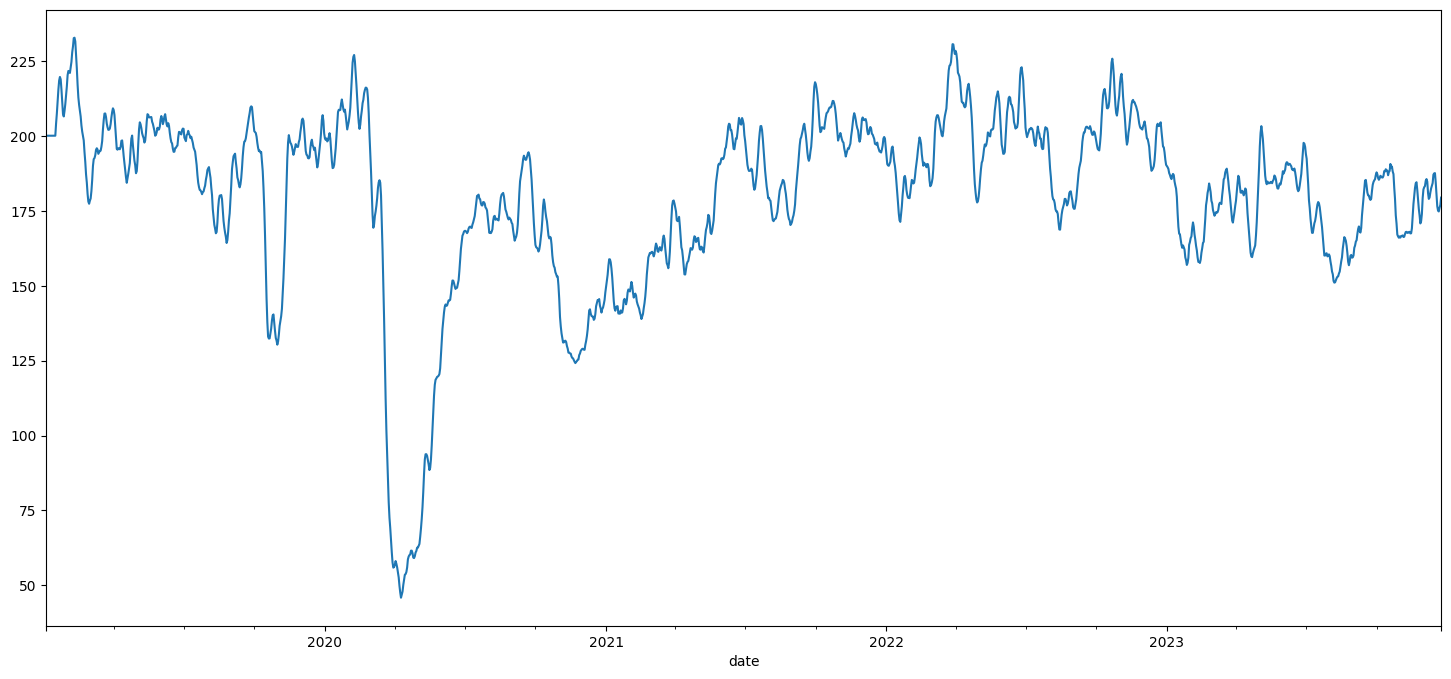

In [38]:
df['target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6'].plot()

In [39]:
df = arsTabularDataset.enc_data
df.drop('target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6', axis=1, inplace=True)
df

,O3_FR26005,O3_FR26010,PM10_FR26005,PM10_FR26014,PM25_FR26005,NO2_FR26005,NO2_FR26014,O3_FR26005%%J-1,O3_FR26005%%J-2,O3_FR26005%%J-3,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-10,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-11,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.178403,0.101405,0.532649,0.330745,0.066912,0.326464,0.721612,0.281023,-0.805563,-1.221684,...,189.666667,189.666667,189.666667,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-04,-0.554787,-0.195616,0.396244,0.330745,0.797608,0.975668,1.335628,-0.179023,0.281523,-0.803836,...,189.666667,189.666667,189.666667,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-05,-0.638428,-0.704794,0.123434,0.198923,0.627679,0.196623,0.353202,-0.555424,-0.178398,0.282569,...,189.666667,189.666667,189.666667,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-06,-0.303864,-0.365342,-0.285782,-0.460184,0.304813,-0.322741,-0.506421,-0.639068,-0.554697,-0.177064,...,189.666667,189.666667,189.666667,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-07,-0.722068,-0.535068,0.396244,0.198923,0.627679,0.975668,0.967218,-0.304490,-0.638319,-0.553127,...,189.666667,189.666667,189.666667,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,-0.554787,-0.450205,-0.558592,-0.460184,-0.120010,0.326464,0.721612,-1.768272,-1.725405,-1.347039,...,182.666667,175.333333,177.666667,7.910879,179.690476,10.341572,179.655914,9.812118,176.619178,13.992984
2023-12-21,-0.052941,0.101405,-1.377023,-1.119292,-0.680777,-0.530487,-0.015208,-0.555424,-1.767216,-1.723102,...,168.333333,182.666667,185.000000,7.430810,180.952381,9.780372,179.408602,9.566806,176.581735,13.952051
2023-12-22,0.574365,0.355994,-1.104213,-0.987470,-0.731756,-0.738232,0.721612,-0.053556,-0.554697,-1.764887,...,168.666667,168.333333,184.000000,8.213423,181.785714,9.481973,179.569892,9.601772,176.543379,13.912195


## Trend prediction

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Tuple

In [41]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False, offset=0):
    if labels == None and type(bins) == int:
        labels = [f'{i+offset}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+offset}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [42]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [43]:
def process(dataset, cols, show=False):
    df = dataset.enc_data.copy(deep=True)
    df = df.filter(items=cols)
    df = df.drop(df.loc['2020-03':'2020-05'].index)

    target = dataset.targets_names[0]

    # y = df[target]
    y = dataset.data[target]
    y = y.drop(y.loc['2020-03':'2020-05'].index)
    result = seasonal_decompose(y, model='additive', period=7)

    #cols.append(target)

    df0 = dataset.data.copy(deep=True)
    df0 = df0.drop('target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6', axis=1)

    df['target'] = result.trend.copy()
    df.dropna(inplace=True)
    df = categorize(df, 'target', bins=5, drop=True, offset=1)
    df['target'] = df['target'].astype(float)
    
    if show:
        # Affichage des composantes
        plt.figure(figsize=(10, 9))
        plt.subplot(411)
        plt.plot(y, label='Série temporelle')
        plt.legend(loc='upper left')

        plt.subplot(412)
        plt.plot(result.trend, label='Tendance')
        plt.legend(loc='upper left')


        # print(df['target'])
        ax3 = plt.subplot(413)  # Capture the Axes for the third subplot
        plt.plot(df['target'], label='Tendance catégorisée')
        ax3.set_ylim(sorted(ax3.get_ylim()))  # Corrects the order of y-axis with 0 at the bottom
        plt.legend(loc='upper left')

        # plt.subplot(413)
        # plt.plot(result.seasonal, label='Saisonnalité')
        # plt.legend(loc='upper left')

        # plt.subplot(414)
        # plt.plot(result.resid, label='Résidu')
        # plt.legend(loc='upper left')
        # plt.tight_layout()
        plt.show()
    
    params = {'eta': 0.05, 
            'objective': 'reg:squarederror', 
            'eval_metric': ['rmse', 'mae'],
            'subsample': 0.7, 
            'colsample_bytree': 1,
            'nthread': -1,
            'device':'cpu'}

    score = 100000
    new_score, reg = teste(df, params, score=score)

    dg = df0.loc[df0.index.year == 2023][:-3]
    dh = df.loc[df.index.year == 2023].drop(columns='target')
    dg['pred'] = reg.predict(xgb.DMatrix(dh)).round(0) * 30 + dg[target].mean()/2
    fig, ax = plt.subplots()
    dg.plot(y=[target, 'pred'], ax=ax)
    (df.loc[df.index.year == 2023, ['target']][:-3] * 30 + dg[target].mean()/2).plot(ax=ax)
    print(f"MAE: {mean_absolute_error(dg[target], dg['pred']):.2f}")
    
    return reg

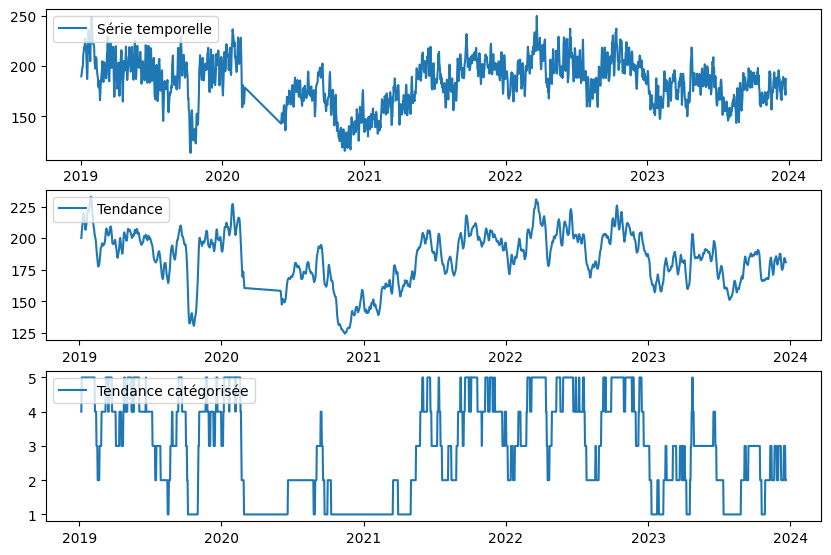

Amélioration avec max_depth=3: 100000.0000 -> 1.1508


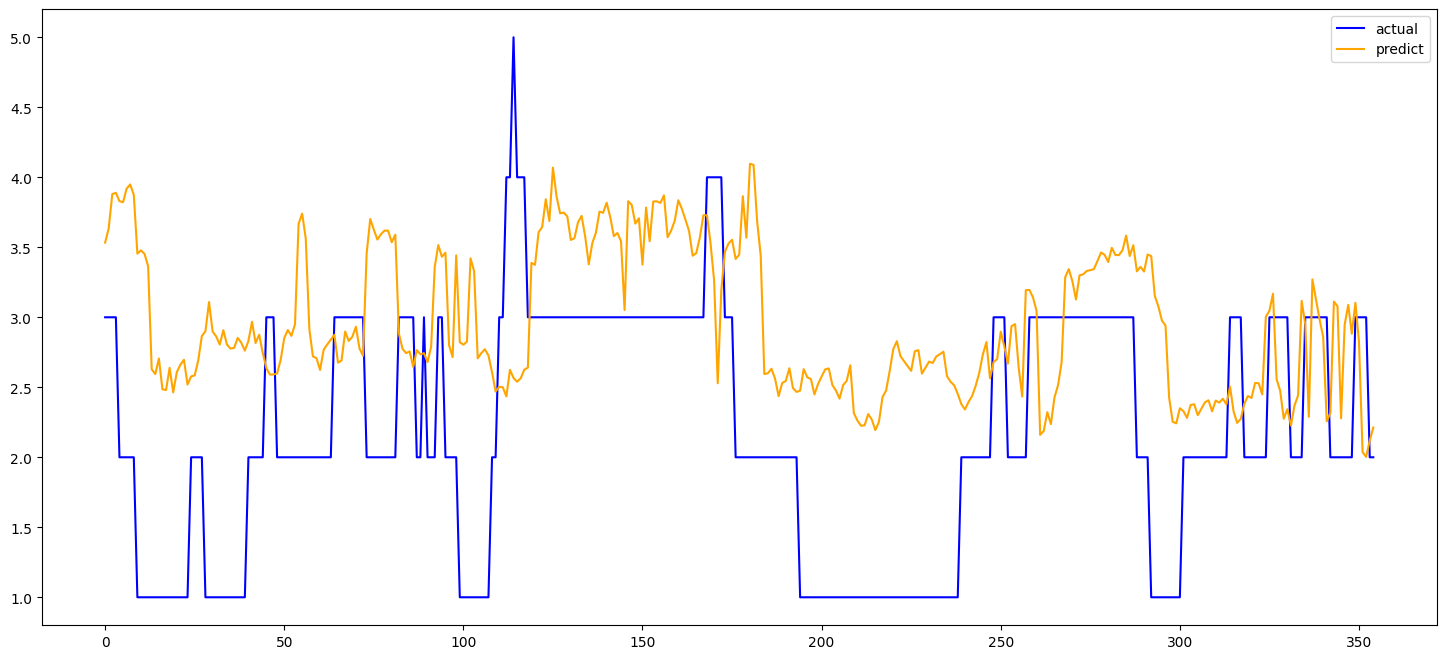

0.28%,1%
0.28%,2%
1.41%,3%
1.69%,4%
2.54%,5%
3.94%,6%
4.79%,7%
5.63%,8%
5.92%,9%
6.48%,10%
7.32%,11%
   - MAE : 0.88 (0.95 sur 2023)
   - MSE : 1.15 (1.27 sur 2023)
MAE: 16.93
best feature : nb_emmergencies%%mean_7J
                                               feature        gain  \
0                             nb_emmergencies%%mean_7J  341.191223   
1    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  264.166473   
2                           trend_migraines%%mean_365J  196.031433   
3    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  121.549622   
4                             inc_varicelle%%mean_365J   74.434410   
..                                                 ...         ...   
265                                O3_FR26005%%std_31J    0.240281   
266                                       PM10_FR26005    0.074374   
267                                    meteo_wdir%%J-5    0.076158   
268                                       PM10_FR26014    0.097205   
269           

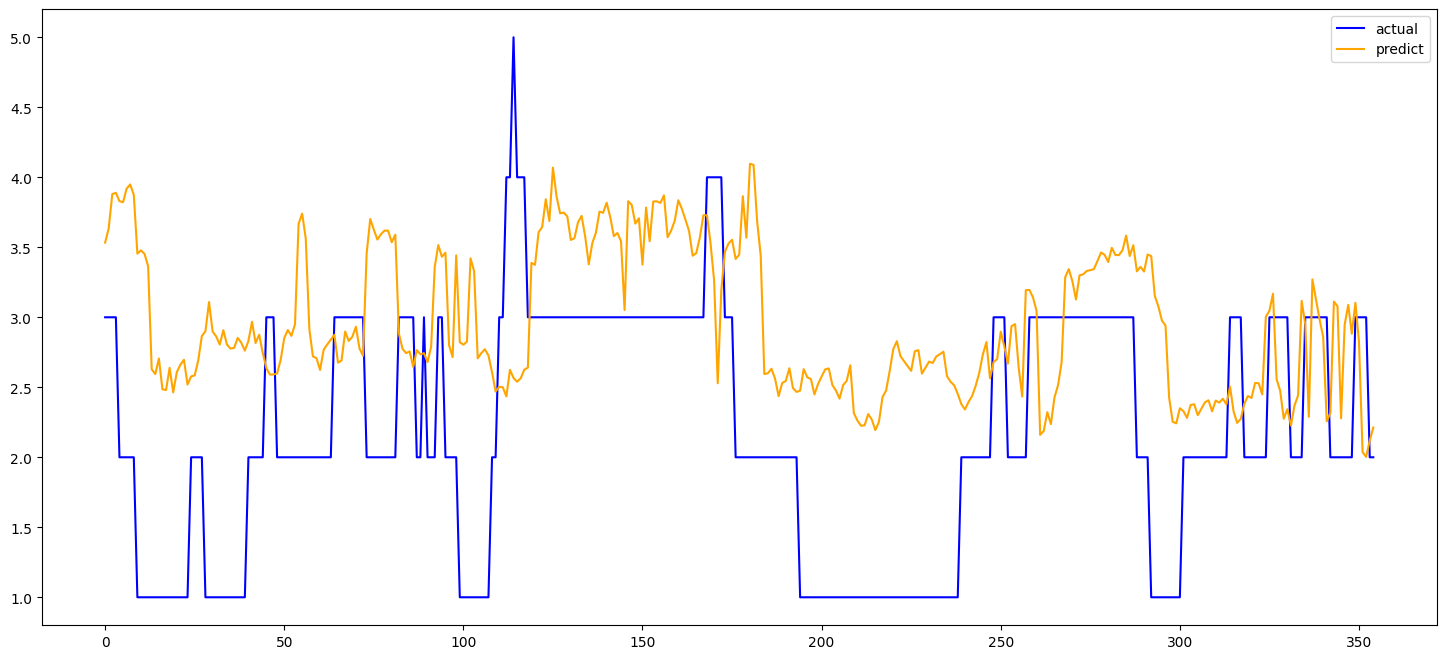

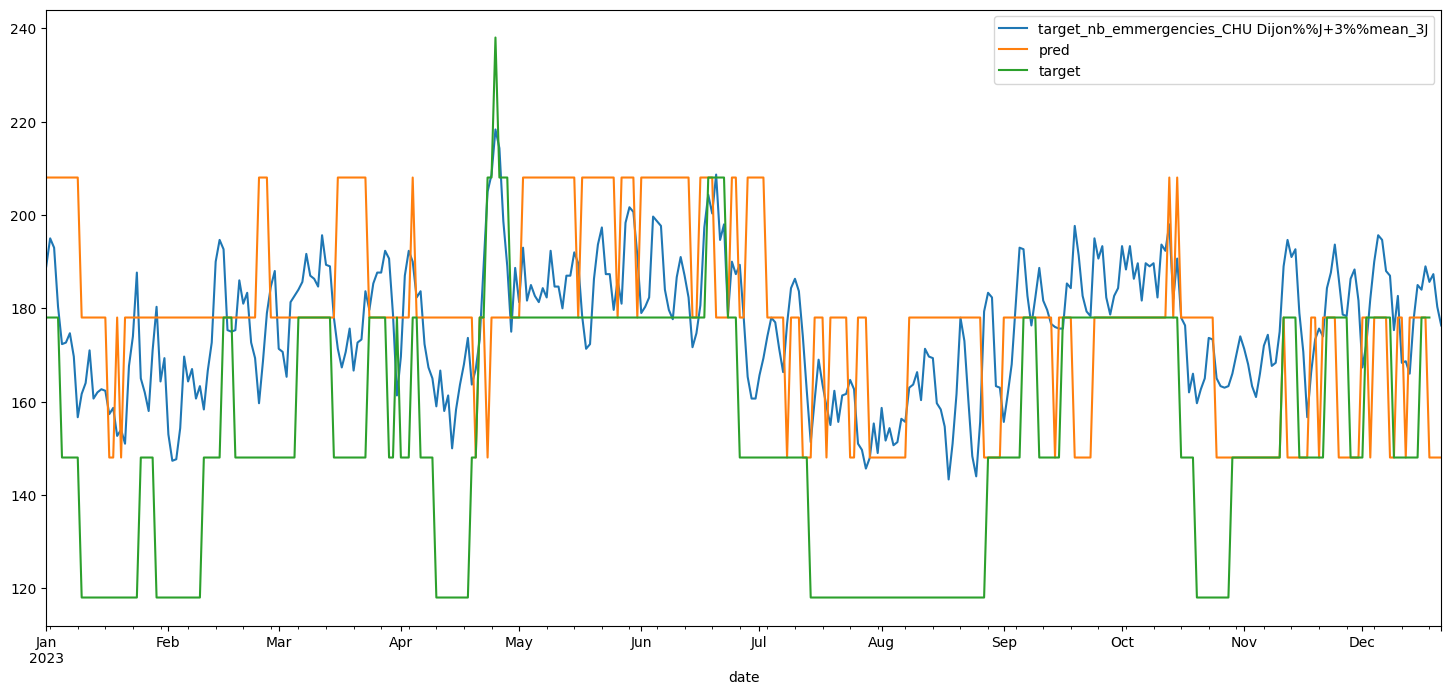

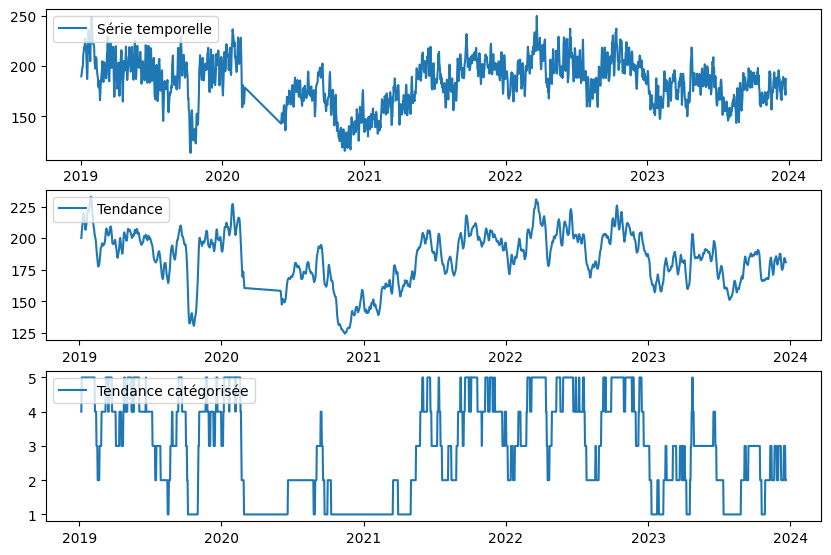

Amélioration avec max_depth=3: 100000.0000 -> 0.9139


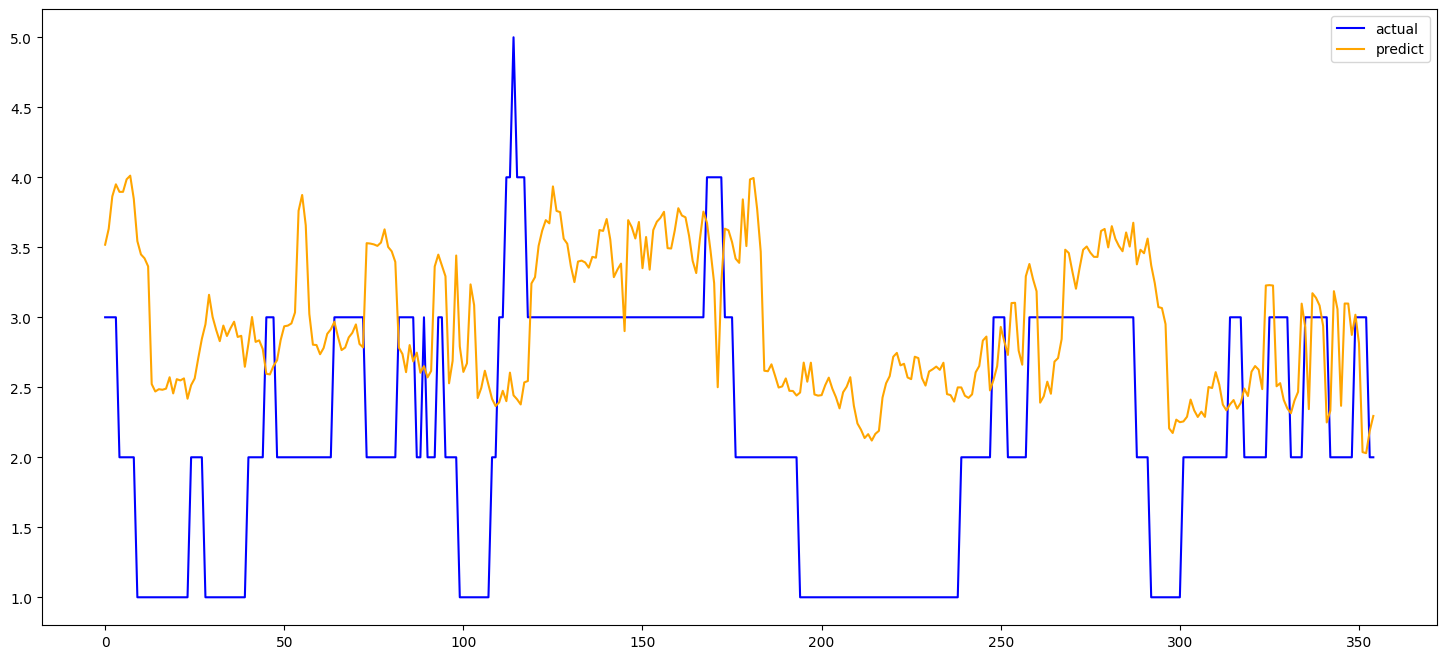

0.28%,1%
0.56%,2%
1.13%,3%
1.97%,4%
2.25%,5%
2.54%,6%
3.38%,7%
4.23%,8%
5.35%,9%
6.76%,10%
7.61%,11%
   - MAE : 0.78 (0.94 sur 2023)
   - MSE : 0.91 (1.23 sur 2023)
MAE: 16.72
best feature : nb_emmergencies%%mean_7J
                                               feature        gain  \
0                             nb_emmergencies%%mean_7J  222.821991   
1                           trend_migraines%%mean_365J  118.004578   
2    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...   93.547249   
3                            nb_emmergencies%%mean_14J   76.245865   
4                             inc_varicelle%%mean_365J   59.272388   
..                                                 ...         ...   
125                           trend_brûlure%%mean_365J    3.042794   
126  target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...    0.902015   
127                                    meteo_tmax%%J-5    1.663110   
128                                         meteo_pres    1.438402   
129           

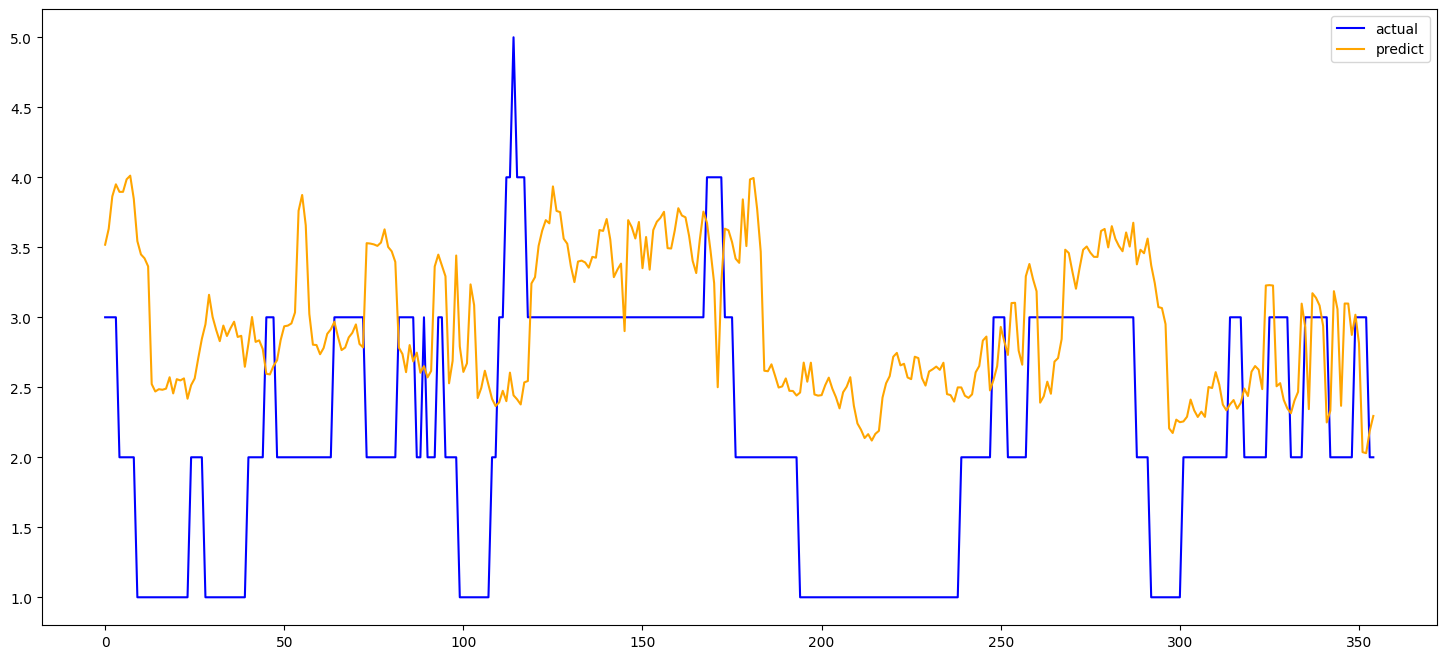

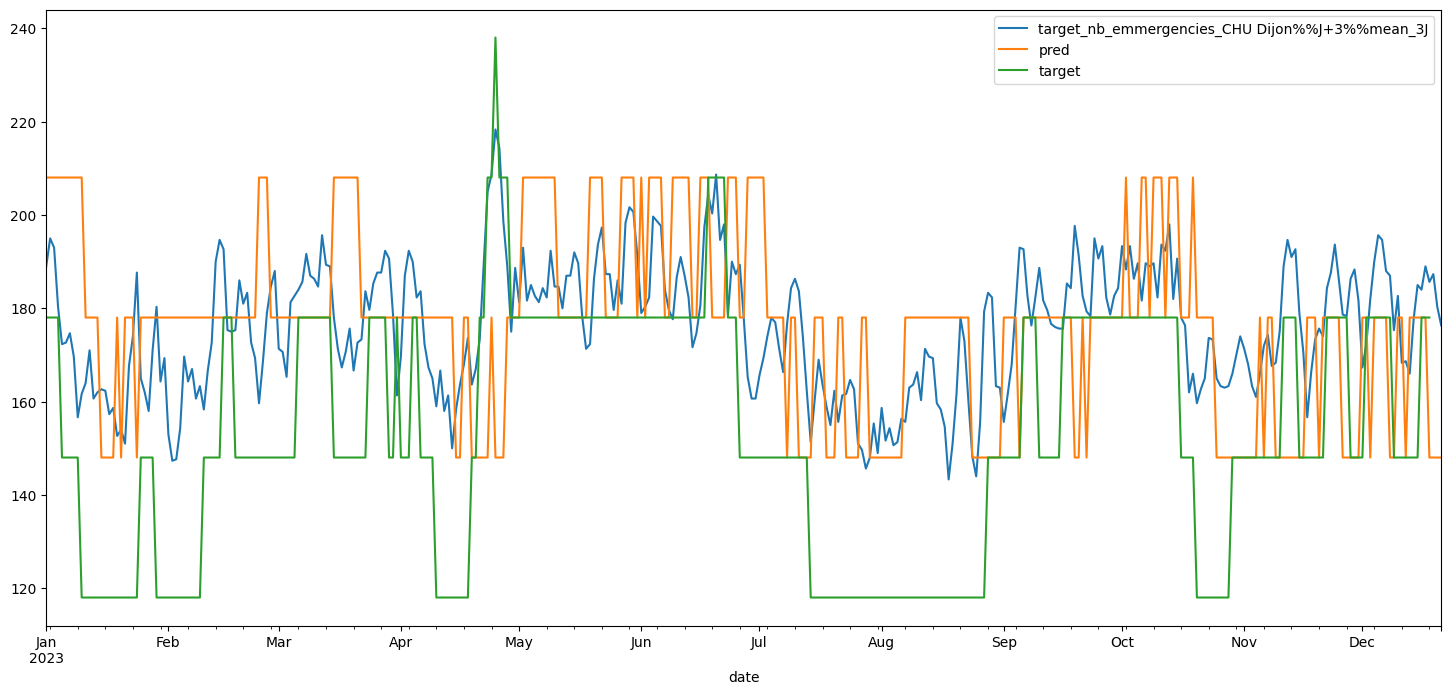

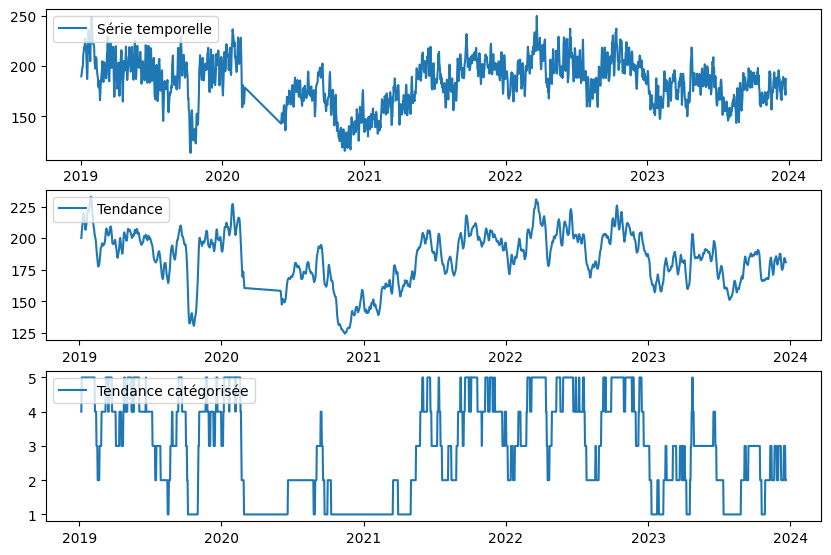

Amélioration avec max_depth=3: 100000.0000 -> 0.9437


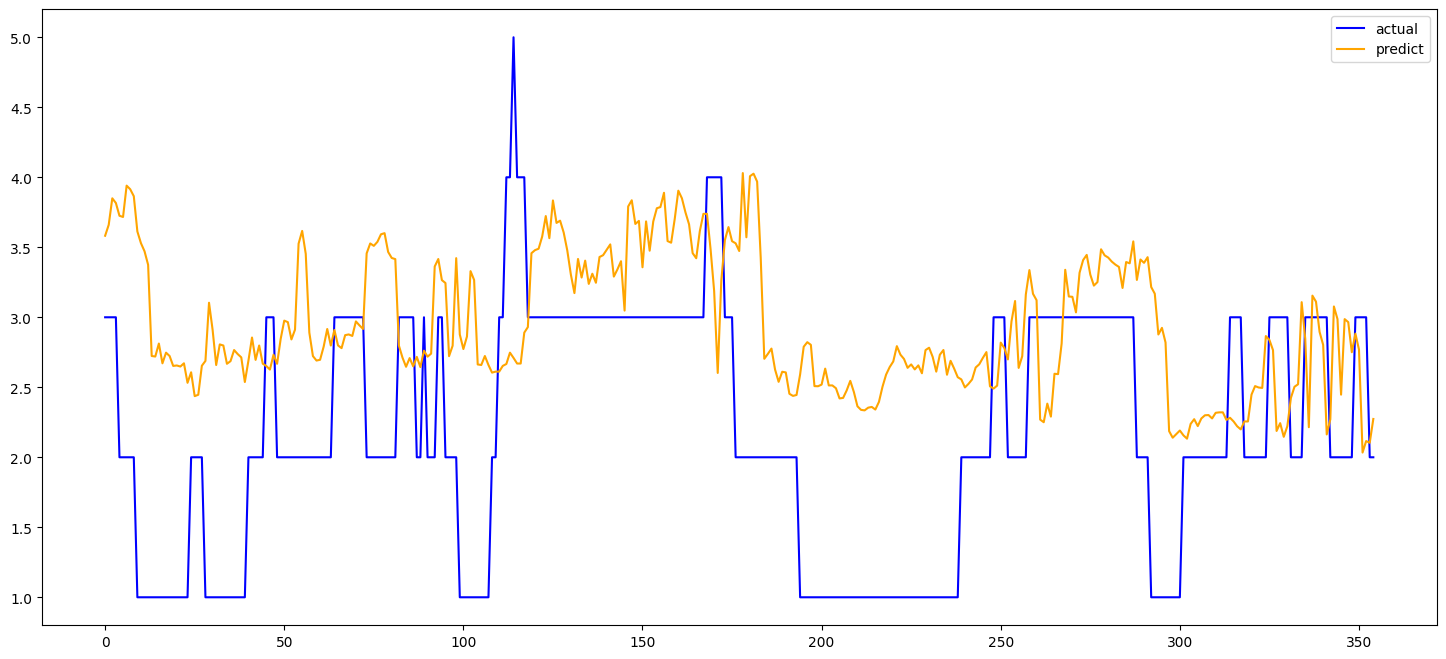

0.00%,1%
0.56%,2%
1.13%,3%
1.69%,4%
2.54%,5%
3.94%,6%
5.07%,7%
6.76%,8%
7.61%,9%
8.45%,10%
10.99%,11%
   - MAE : 0.80 (0.93 sur 2023)
   - MSE : 0.94 (1.23 sur 2023)
MAE: 16.03
best feature : nb_emmergencies%%mean_7J
                                              feature        gain       cover  \
0                            nb_emmergencies%%mean_7J  244.628815  482.476196   
1   target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  173.474747  486.250000   
2                          trend_migraines%%mean_365J  147.602478  579.000000   
3                            inc_varicelle%%mean_365J   77.085999  668.238098   
4   target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...   60.742538  392.500000   
..                                                ...         ...         ...   
59                               meteo_tavg%%mean_31J    6.742638  183.285721   
60                            trend_douleur%%mean_14J    5.212177  208.714279   
61                              NO2_FR26014%%std_365J 

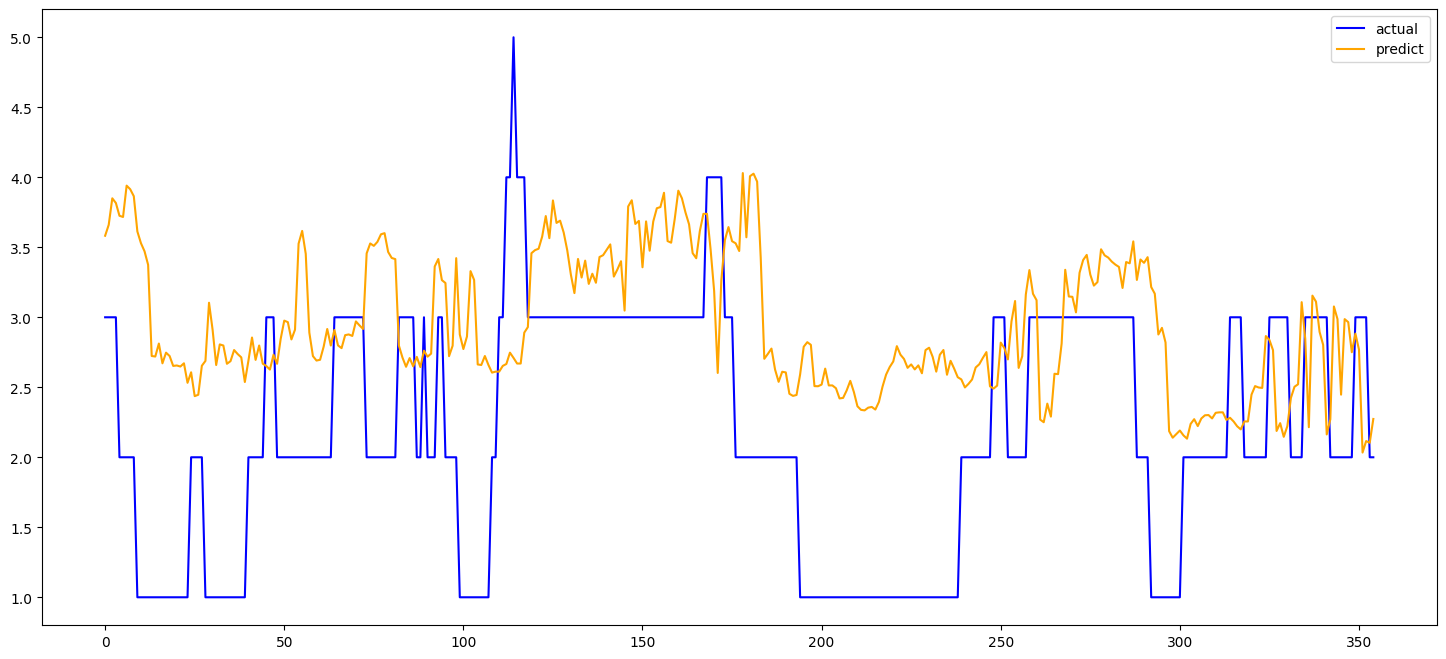

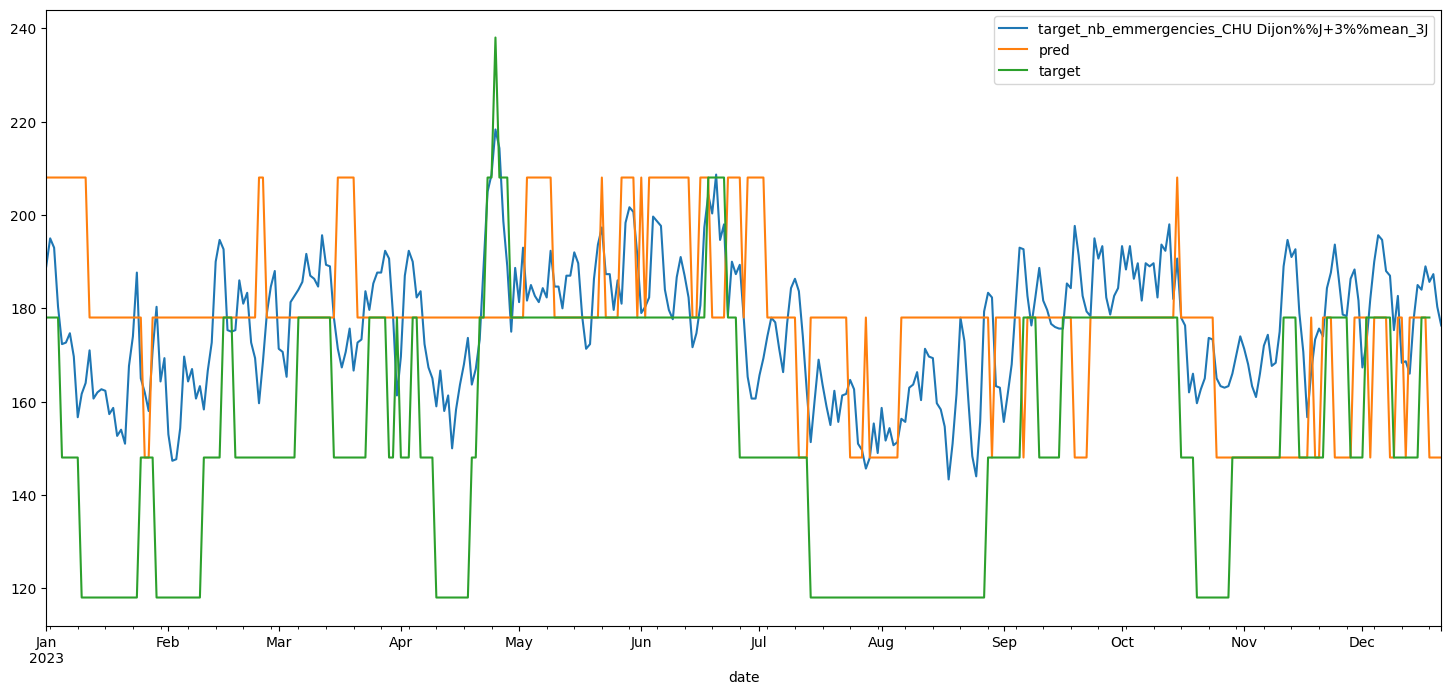

In [44]:
nb_features = len(arsTabularDataset.enc_data.columns) - 1
cols = arsTabularDataset.enc_data.columns
while nb_features > 50:
    # launche all process
    reg = process(arsTabularDataset, cols, show=True)


    # Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
    importance_gain = reg.get_score(importance_type='gain')
    importance_cover = reg.get_score(importance_type='cover')
    importance_weight = reg.get_score(importance_type='weight')

    df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
    df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
    df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

    di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

    di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

    di['gain_norm'] = di['gain'] / di['gain'].sum()
    di['cover_norm'] = di['cover'] / di['cover'].sum()
    di['weight_norm'] = di['weight'] / di['weight'].sum()

    w_gain = 0.5
    w_cover = 0.3
    w_weight = 0.2

    di['importance'] = (di['gain_norm'] * w_gain) + (di['cover_norm'] * w_cover) + (di['weight_norm'] * w_weight)

    di.sort_values(by='importance', ascending=False, inplace=True)
    di['rank'] = di['importance'].rank(ascending=False)

    di.reset_index(inplace=True)
    di.rename(columns={'index': 'feature'}, inplace=True)
    print('best feature :', di.loc[di['rank'] == 1, 'feature'].values[0])
    print(di[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])
    cols = di.loc[di['rank'] < int(len(di)/2), 'feature']
    nb_features = len(cols)
